In [27]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from src.torch_utils import train_model, plot_training_history, evaluate_model, visualize_model_evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

seed = 7
np.random.seed(seed)

In [3]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(DEVICE)

mps


In [4]:
base_path = "../data"

df = pd.read_csv(os.path.join(base_path, "jena_climate_2009_2016.csv"), index_col=0)
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
df.shape

(420551, 14)

In [6]:
df.dtypes

p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

## Create Time Series Generator

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, data, lookback, delay, step, min_index, max_index, target_col_idx=1, shuffle=False):
        """
        Custom PyTorch Dataset for weather data
        
        Args:
            data: Normalized numpy array of shape (samples, features)
            lookback: How many timesteps back to use as input features
            delay: How many timesteps in future to predict
            step: Data will be sampled every `step` timesteps
            min_index, max_index: Indices delimiting which timesteps to draw from
            target_col_idx: Index of the target column (temperature)
            shuffle: Whether to shuffle samples
        """
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.step = step
        self.min_index = min_index
        self.max_index = max_index
        self.target_col_idx = target_col_idx
        self.shuffle = shuffle
        
        self.samples = (max_index - min_index - lookback - delay) // step + 1
        
        self.indices = np.arange(self.samples) * step + min_index
        if shuffle:
            np.random.shuffle(self.indices)
    
    def __len__(self):
        return self.samples
    
    def __getitem__(self, idx):
        # Get the position in the original dataset
        position = self.indices[idx]
        
        # Extract the input sequence
        # Shape: (lookback//step, num_features)
        x = np.zeros((self.lookback//self.step, self.data.shape[1]))
        for i in range(self.lookback//self.step):
            x[i] = self.data[position + i * self.step]
        
        # Extract the target (temperature at delay timesteps in the future)
        target_position = position + self.lookback + self.delay - 1
        y = self.data[target_position, self.target_col_idx]
        
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [8]:
def normalize_data(data, train_indices=None):
    """
    Normalize each column (feature) independently.
    
    Args:
        data: numpy array of shape (samples, features)
        train_indices: indices to use for computing mean and std
                      (if None, use all data)
    
    Returns:
        normalized_data: normalized numpy array
        means: mean of each feature
        stds: standard deviation of each feature
    """
    if train_indices is None:
        train_indices = np.arange(len(data))
        
    means = np.mean(data[train_indices], axis=0)
    stds = np.std(data[train_indices], axis=0)
    
    stds[stds == 0] = 1.0
    
    normalized_data = (data - means) / stds
    return normalized_data, means, stds

## Create DataLoaders

In [9]:
num_timesteps = len(df)
train_end = 200_000
val_end = 300_000

train_indices = np.arange(train_end)
normalized_data, means, stds = normalize_data(df.to_numpy(), train_indices)

In [10]:
lookback = 1440
steps = 6
delay = 144 

train_dataset = WeatherDataset(
    data=normalized_data,
    lookback=lookback,
    delay=delay,
    step=steps,
    min_index=0,
    max_index=train_end,
    target_col_idx=1,
    shuffle=True
)

val_dataset = WeatherDataset(
    data=normalized_data,
    lookback=lookback,
    delay=delay,
    step=steps,
    min_index=train_end,
    max_index=val_end,
    target_col_idx=1,
    shuffle=False
)

test_dataset = WeatherDataset(
    data=normalized_data,
    lookback=lookback,
    delay=delay,
    step=steps,
    min_index=val_end,
    max_index=num_timesteps,
    target_col_idx=1,
    shuffle=False
)

In [11]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Evaluate Naive Model

In [12]:
def evaluate_naive_method(loader):
    maes = []
    for samples, targets in loader:
        preds = samples[:, -1, 1]
        mae = torch.mean(torch.abs(preds - targets))
        maes.append(mae.item())
    return np.mean(maes)

In [13]:
naive_mae = evaluate_naive_method(val_loader)
print(f"Naive method MAE on validation set: {naive_mae}")

Naive method MAE on validation set: 0.28584787151379176


In [14]:
print(f"Celcius MAE on val: {naive_mae * stds[1]}")

Celcius MAE on val: 2.5304680202259835


In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        # LSTM Layer:
        # - 32 units, as in the Keras model
        # - input_size is the number of features
        self.lstm = nn.LSTM(input_size, 32, batch_first=True)
        # Dense Layer:
        # - 32 (from LSTM) to 1 output (since we're predicting one value)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        # LSTM expects input of shape (batch_size, sequence_length, features)
        lstm_out, _ = self.lstm(x)
        # We only care about the last output of LSTM for prediction
        # Assuming variable length sequences, we take the last output from each batch
        if x.dim() == 3:  # (batch, seq, feature)
            lstm_out = lstm_out[:, -1, :]  # Take last time step
        else:  # If not batched
            lstm_out = lstm_out[-1, :]  # Take last time step

        # Pass through dense layer
        output = self.dense(lstm_out)
        return output

In [36]:
input_size = 14
model = LSTMModel(input_size)

criterion = nn.L1Loss()
optimizer = optim.RMSprop(model.parameters())

In [37]:
history, model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    num_epochs=10
)


Epoch 1/10
--------------------


Epoch 1/10 [Val]: 100%|██████████| 129/129 [00:03<00:00, 38.75it/s, loss=0.2793, acc=0.0000]


Train Loss: 0.3092 | Train Acc: 0.0000
Val Loss: 0.2793 | Val Acc: 0.0000
New best model (val_loss: 0.2793)

Epoch 2/10
--------------------


Epoch 2/10 [Val]: 100%|██████████| 129/129 [00:02<00:00, 45.11it/s, loss=0.2748, acc=0.0000]


Train Loss: 0.2850 | Train Acc: 0.0000
Val Loss: 0.2748 | Val Acc: 0.0000
New best model (val_loss: 0.2748)

Epoch 3/10
--------------------


Epoch 3/10 [Val]: 100%|██████████| 129/129 [00:02<00:00, 44.58it/s, loss=0.2722, acc=0.0000]


Train Loss: 0.2765 | Train Acc: 0.0000
Val Loss: 0.2722 | Val Acc: 0.0000
New best model (val_loss: 0.2722)

Epoch 4/10
--------------------


Epoch 4/10 [Val]: 100%|██████████| 129/129 [00:02<00:00, 46.41it/s, loss=0.2849, acc=0.0000]


Train Loss: 0.2708 | Train Acc: 0.0000
Val Loss: 0.2849 | Val Acc: 0.0000

Epoch 5/10
--------------------


Epoch 5/10 [Val]: 100%|██████████| 129/129 [00:02<00:00, 46.73it/s, loss=0.2737, acc=0.0000]


Train Loss: 0.2657 | Train Acc: 0.0000
Val Loss: 0.2737 | Val Acc: 0.0000

Epoch 6/10
--------------------


Epoch 6/10 [Val]: 100%|██████████| 129/129 [00:02<00:00, 45.12it/s, loss=0.2732, acc=0.0000]


Train Loss: 0.2596 | Train Acc: 0.0000
Val Loss: 0.2732 | Val Acc: 0.0000

Epoch 7/10
--------------------


Epoch 7/10 [Val]: 100%|██████████| 129/129 [00:03<00:00, 41.70it/s, loss=0.2794, acc=0.0000]


Train Loss: 0.2526 | Train Acc: 0.0000
Val Loss: 0.2794 | Val Acc: 0.0000

Epoch 8/10
--------------------


Epoch 8/10 [Val]: 100%|██████████| 129/129 [00:05<00:00, 23.84it/s, loss=0.2931, acc=0.0000]


Train Loss: 0.2473 | Train Acc: 0.0000
Val Loss: 0.2931 | Val Acc: 0.0000

Epoch 9/10
--------------------


Epoch 9/10 [Val]: 100%|██████████| 129/129 [00:03<00:00, 37.70it/s, loss=0.2843, acc=0.0000]


Train Loss: 0.2428 | Train Acc: 0.0000
Val Loss: 0.2843 | Val Acc: 0.0000

Epoch 10/10
--------------------


Epoch 10/10 [Val]: 100%|██████████| 129/129 [00:03<00:00, 41.60it/s, loss=0.2955, acc=0.0000]


Train Loss: 0.2357 | Train Acc: 0.0000
Val Loss: 0.2955 | Val Acc: 0.0000

Training completed in 2m 10s
Best validation loss: 0.2722


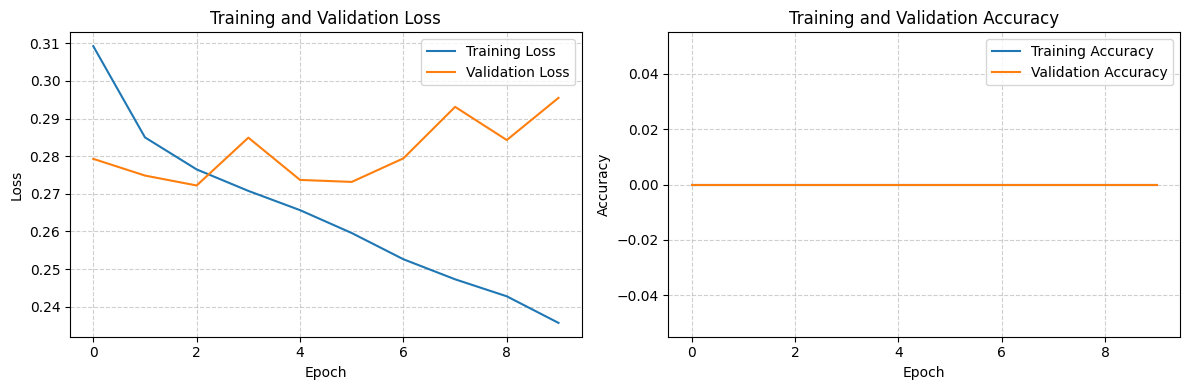

In [38]:
plot_training_history(history)

In [39]:
eval_metrics = evaluate_model(
    model=model,
    test_loader=test_loader,
    criterion=criterion, 
    device=DEVICE, 
)

Evaluating: 100%|██████████| 155/155 [00:04<00:00, 36.46it/s]


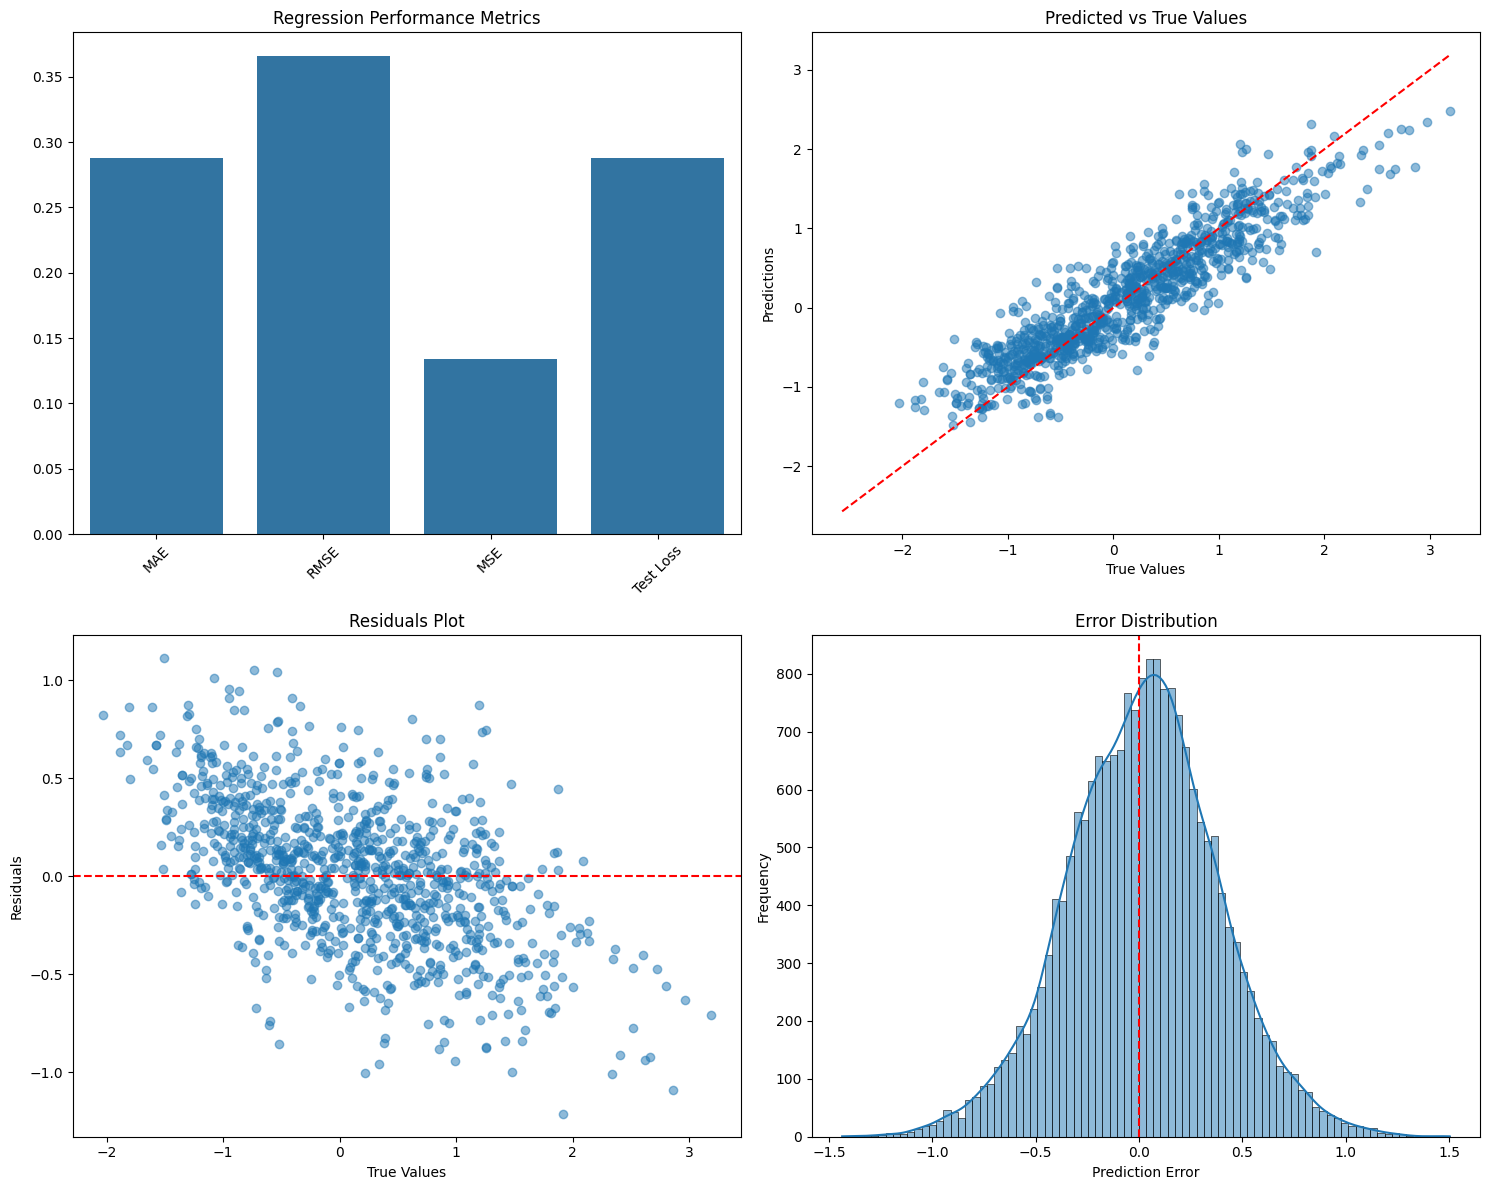

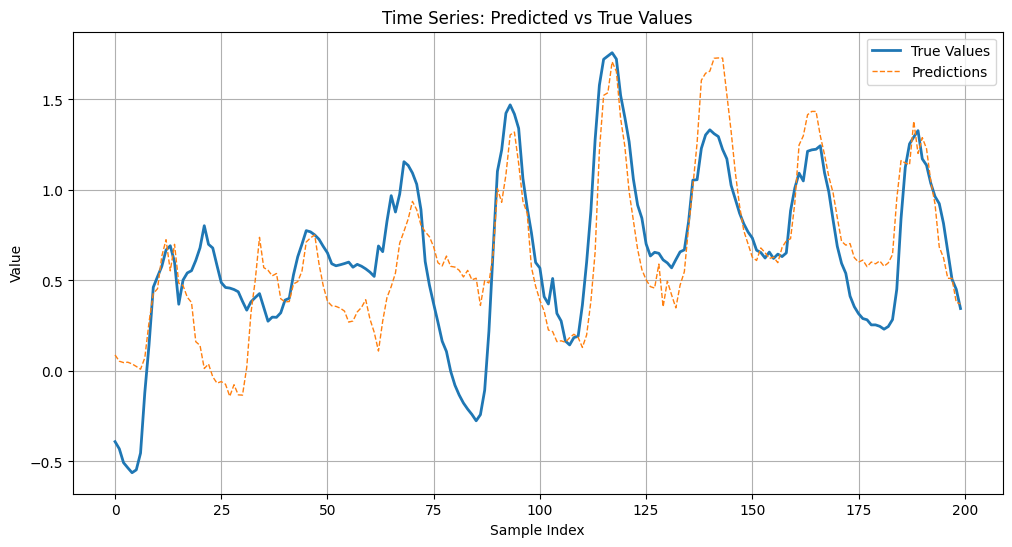

{'MAE': np.float32(0.28806347),
 'RMSE': np.float32(0.36563),
 'MSE': np.float32(0.1336853),
 'Test Loss': 0.2880634740040094}

In [40]:
visualize_model_evaluation(eval_metrics)